## PSD+SVM Method

In [1]:
import os
import numpy as np
from sklearn.model_selection import KFold
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression

from helper_functions import *
from latency_helpers import *
from loading_functions import *
from file_paths import *
from models import *
import importlib

In [59]:

import models
importlib.reload(models)
from models import *

In [30]:
import loading_functions
importlib.reload(loading_functions)
from loading_functions import *

### Load Features

In [38]:
feat_name = 'PSD'
t_seg = 20 #ms
n_per_seg = 1024
interferences = ['WIFI', 'BLUE', 'BOTH', 'CLEAN']
output_name = 'bi'
feat_format = 'ARR'
which_dataset = 'dronerf'

if which_dataset == 'dronerf':
    print('Loading DroneRF Dataset')
    highlow = 'H'
    dataset = DroneRFTorch(dronerf_feat_path, feat_name, t_seg, n_per_seg,
                       feat_format, output_name, highlow)
elif which_dataset == 'dronedetect':
    print('Loading DroneDetect Dataset')
    dataset = DroneDetectTorch(dronedetect_feat_path, feat_name, t_seg, n_per_seg, feat_format,
                                    output_name, interferences)
X_use, y_use = dataset.get_arrays()

# Set fixed number of samples
n_samps = 1000
i_test= random.sample(range(len(dataset)), n_samps)
# i_test= list(range(0,2712,10))
X_use, y_use = dataset.__getitem__(i_test)


Loading DroneRF Dataset
/home/kzhou/main/Features_DroneRF/ARR_PSD_H_1024_20/
dataset size 2712
shape of each item (513,)


### Run Model

In [60]:
model = PsdSVM(t_seg, n_per_seg)

In [47]:
accs, f1s, runts = model.run_cv(X_use, y_use, k_fold=5)

1it [00:00,  2.50it/s]

Fold 1: Accuracy: 0.971,	 F1: 0.97, 	 Runtime: 0.000191


2it [00:00,  2.73it/s]

Fold 2: Accuracy: 0.985,	 F1: 0.985, 	 Runtime: 0.000187


3it [00:01,  2.83it/s]

Fold 3: Accuracy: 0.978,	 F1: 0.977, 	 Runtime: 0.000186


4it [00:01,  2.83it/s]

Fold 4: Accuracy: 0.994,	 F1: 0.994, 	 Runtime: 0.000181


5it [00:01,  2.82it/s]

Fold 5: Accuracy: 0.987,	 F1: 0.987, 	 Runtime: 0.000187
PSD+SVM 5 Fold CV acc: 0.983, F1: 0.983, Run-time: 0.186ms


In [61]:
# search through parameters
Cs=list(map(lambda x:pow(2,x),range(-3,10,2)))
gammas=list(map(lambda x:pow(2,x),range(-3,10,2)))
parameters = {'C':Cs, 'gamma':gammas}

k_fold=5

accs, f1s, runts, best_params = model.run_gridsearch(X_use, y_use, parameters, k_fold)

Fold 1 Best Parameters: {'C': 128, 'gamma': 0.125}
Fold 1: Accuracy: 1.0,	 F1: 1.0, 	 Runtime: 0.000127
Fold 2 Best Parameters: {'C': 128, 'gamma': 0.5}
Fold 2: Accuracy: 0.994,	 F1: 0.994, 	 Runtime: 0.000182
Fold 3 Best Parameters: {'C': 512, 'gamma': 0.125}
Fold 3: Accuracy: 0.998,	 F1: 0.998, 	 Runtime: 0.000119
Fold 4 Best Parameters: {'C': 512, 'gamma': 0.125}
Fold 4: Accuracy: 0.998,	 F1: 0.998, 	 Runtime: 0.000116
Fold 5 Best Parameters: {'C': 8, 'gamma': 0.5}
Fold 5: Accuracy: 0.996,	 F1: 0.996, 	 Runtime: 0.000204
PSD+SVM 5 Fold GridSearch CV acc: 0.997, F1: 0.997, Run-time: 0.149ms


### Visualize Results

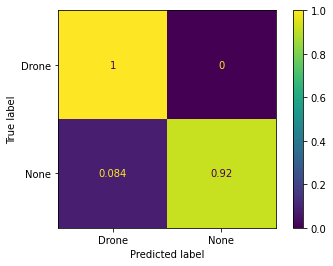

In [65]:
# Set-up train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_use, 
                                                    y_use, 
                                                    test_size=0.33, 
                                                    random_state=None)

# Train & Test
model.train(X_train, y_train)
preds = model.predict(X_test)
show_confusion_matrix(dataset, y_test, preds)

### Save Model

In [10]:
to_train_all = True # whether to retrain using all the data
model_name = which_dataset+'_'+'SVM'+'_'+str(feat_name)+'_'+str(n_per_seg)+'_'+str(t_seg)+'_'+str(int(to_train_all))
model_path = '../temp_figs/'

if to_train_all:
    model.train(X_use, y_use)

model.save(model_path, model_name)

# pickle.dump(svc, open(model_path+model_name, 'wb'))

Model saved as: ../temp_figs/SVM_PSD_1024_20_1


-----------------

## Pilot Test- Try Model on GamutRF data

In [2]:
data_path = '/home/kzhou/Data/S3/leesburg_worker1/Features/'
Xgamut = load_gamut_features(data_path, 'psd')

100%|███████████████████████████████████████| 115/115 [00:00<00:00, 2255.41it/s]


In [7]:
# normalize data
## Apply normalization
X_gamut_norm = Xgamut
for n in range(len(Xgamut)):
    X_gamut_norm[n] = Xgamut[n]/max(Xgamut[n])

X_gamut_norm.max()

1.0

In [8]:
# Feed data through trained SVM model
y_gamut_pred = model.predict(X_gamut_norm)

In [9]:
y_gamut_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1,